# Tutorial Introduction

Repeat measure experimental designs (e.g. time series) are a valid and powerful method to control for inter-individual variation. However, conventional dimensionality reduction methods can not account for the high-correlation of each subject to itself at a later time point. This inherent correlation structure can cause subject grouping to confound or even outweigh important phenotype groupings. To address this we will use Compositional Tensor Factorization (CTF) which we provide in the software package [gemelli](https://github.com/biocore/gemelli). CTF can account for repeated measures, compositionality, and sparsity in microbiome data.

In this tutorial we use _gemelli_ to perform CTF on a time series dataset comparing Crohn's and control subjects over a period of 25 weeks published in [Vázquez-Baeza et al](https://gut.bmj.com/content/67/9/1743). First we will download the processed data originally from [here](https://qiita.ucsd.edu/study/description/2538#). This data can be downloaded with the following links:

* **Table** (table.biom) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/IBD-2538/data/table.biom)
* **Rarefied Table** (rarefied-table.biom) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/IBD-2538/data/rarefied-table.biom)
* **Sample Metadata** (metadata.tsv) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/IBD-2538/data/metadata.tsv)
* **Feature Metadata** (taxonomy.tsv) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/IBD-2538/data/taxonomy.tsv)
* **Tree** (sepp-insertion-tree.nwk) | [download](https://github.com/biocore/gemelli/tree/master/ipynb/tutorials/IBD-2538/data/sepp-insertion-tree.nwk)

**Note**: This tutorial assumes you have installed [QIIME2](https://qiime2.org/) using one of the procedures in the [install documents](https://docs.qiime2.org/2020.2/install/). This tutorial also assumed you have installed, [Qurro](https://github.com/biocore/qurro) and [gemelli](https://github.com/biocore/gemelli).

First, we will make a tutorial directory and download the data above and move the files to the `IBD-2538/data` directory:

```bash
mkdir IBD-2538
```
```bash
# move downloaded data here
mkdir IBD-2538/data
```


First we will import our data with python:

In [1]:
import os
import warnings
import pandas as pd
from biom import Table, load_table
from skbio import TreeNode, read
# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

# import table(s)
table = load_table('IBD-2538/data/table.biom')
# import metadata
metadata = pd.read_csv('IBD-2538/data/metadata.tsv', sep='\t',
                       dtype={'sample_name':'str'}).set_index('sample_name')
# import taxonomy
taxonomy = pd.read_csv('IBD-2538/data/taxonomy.tsv', sep='\t',
                       index_col=0, dtype={'sample_name':'str'})


Next, we will demonstrate the issues with using conventional dimensionality reduction methods on time series data. To do this we will perform PCoA dimensionality reduction on weighted and unweighted UniFrac $\beta$-diversity distances. We will also run Aitchison Robust PCA which is built on the same framework as CTF but does not account for repeated measures.


In [2]:
import unifrac as qsu
from emperor import Emperor
from gemelli.rpca import rpca
from skbio.stats.ordination import pcoa

# save variables
rarefied_table, phylogeny = ('IBD-2538/data/rarefied-table.biom',
                             'IBD-2538/data/sepp-insertion-tree.nwk')
variance_adjusted, bypass_tips = False, False

# generate distances
unweighted_unifrac_distance = qsu.ssu(str(rarefied_table), str(phylogeny), 'unweighted',
                                          variance_adjusted, 1.0, bypass_tips, 1.0) 
weighted_unifrac_distancea_dist = qsu.ssu(str(rarefied_table), str(phylogeny), 'weighted_unnormalized',
                                          variance_adjusted, 1.0, bypass_tips, 1.0)

# perform PCoA
unweighted_unifrac_pcoa = pcoa(weighted_unifrac_distancea_dist)
weighted_unifrac_pcoa = pcoa(unweighted_unifrac_distance)

# run RPCA and plot with emperor
rpca_biplot, rpca_distance = rpca(table.copy())

# use emperor to plot
os.makedirs('IBD-2538/core-metric-output', exist_ok=True)
# unweighted plot
emp = Emperor(unweighted_unifrac_pcoa, metadata, remote='.')
output_folder = 'IBD-2538/core-metric-output/unweighted_unifrac_emperor_plot' 
os.makedirs(output_folder, exist_ok=True)
with open(os.path.join(output_folder, 'index.html'), 'w') as f:
    f.write(emp.make_emperor(standalone=True))
    emp.copy_support_files(output_folder)
# weighted plot
emp = Emperor(weighted_unifrac_pcoa, metadata, remote='.')
output_folder = 'IBD-2538/core-metric-output/weighted_emperor_unifrac_plot' 
os.makedirs(output_folder, exist_ok=True)
with open(os.path.join(output_folder, 'index.html'), 'w') as f:
    f.write(emp.make_emperor(standalone=True))
    emp.copy_support_files(output_folder)
# RPCA plot   
emp = Emperor(rpca_biplot, metadata, remote='.')
output_folder = 'IBD-2538/core-metric-output/rpca_emperor_plot' 
os.makedirs(output_folder, exist_ok=True)
with open(os.path.join(output_folder, 'index.html'), 'w') as f:
    f.write(emp.make_emperor(standalone=True))
    emp.copy_support_files(output_folder)


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.9329142170862077 and the largest is 24.591847406777045.
  RuntimeWarning
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the result


Now we can visualize the sample groupings by host subject ID and IBD with [Emperor](https://biocore.github.io/emperor/). From this we can see the PCoA samples clearly separate by host subject ID which in some cases (e.g. UniFrac) can overwhelm the control (blue) v. Crohn's disease (orange) sample groupings. Even in the case where the IBD grouping is not completely lost (e.g. RPCA) we can still see confounding groupings in the control (blue) groups by subject ID. This can complicate the interpretation of these analysis.    
 
![image.png](etc/subjectidsgroups.png)

This confounding effect can also be observed in the statistics performed on pairwise $\beta$-diversity distances (e.g. PERMANOVA). For the purpose of exploring distance matrices, [q2-longitudinal](https://msystems.asm.org/content/3/6/e00219-18) has many excellent methods to account for repeated measures data. You can find the q2-longitudinal tutorial [here](https://docs.qiime2.org/2020.2/tutorials/longitudinal/).


# Compositional Tensor Factorization (CTF) Introduction


In order to account for the correlation among samples from the same subject we will employ compositional tensor factorization (CTF). CTF builds on the ability to account for compositionality and sparsity using the robust center log-ratio transform covered in the RPCA tutorial (found [here](https://forum.qiime2.org/t/robust-aitchison-pca-beta-diversity-with-deicode)) but restructures and factors the data as a tensor. Here we will run CTF through _gemelli_ and explore/interpret the different results. 


To run CTF we only need to run one command (gemelli ctf). The required input requirements are:

1. table
    - The table is of type `FeatureTable[Frequency]` which is a table where the rows are features (e.g. ASVs/microbes), the columns are samples, and the entries are the number of sequences for each sample-feature pair.
2. sample-metadata
    - This is a QIIME2 formatted [metadata](https://docs.qiime2.org/2020.2/tutorials/metadata/) (e.g. tsv format) where the rows are samples matched to the (1) table and the columns are different sample data (e.g. time point).  
3. individual-id-column
    - This is the name of the column in the (2) metadata that indicates the individual subject/site (e.g. subject ID) that was sampled repeatedly.
4. state-column
    - This is the name of the column in the (2) metadata that indicates the numeric repeated measure (e.g., Time in months/days) or non-numeric category (i.e. decade/body-site). 
5. output-dir
    - The desired location of the output. We will cover each output independently below.  

There are also optional input parameters:

* ( _Optional_ ) feature-metadata-file
    - This is a metadata file (e.g. tsv, or `FeatureTable[Taxonomy]` .qza) where the rows are matched to the table features and the columns are feature metadata such as taxonomy, gene pathway, etc... 

In this tutorial our individual-id-column is `host_subject_id` and our state-column is different time points denoted as `timepoint` in the sample metadata. Now we are ready to run CTF:


In [3]:
from gemelli.ctf import ctf

# run CTF
ctf_results = ctf(table.copy(), metadata.reindex(table.ids()),
                  'host_subject_id',
                  'timepoint',
                  feature_metadata=taxonomy)
# expand the results
subject_biplot = ctf_results[0]
state_biplot = ctf_results[1]
distance_matrix = ctf_results[2]
state_subject_ordination = ctf_results[3]
state_feature_ordination = ctf_results[4]



We will now cover the output files:
* subject_biplot
* state_biplot
* distance_matrix
* state_subject_ordination
* state_feature_ordination


First, we will explore the `subject_biplot` which is an ordination where dots represent _subjects_ not _samples_ and arrows represent features (e.g. ASVs). First, we will need to aggregate the metadata by subject (i.e. collapsing the metadata of all samples from a given subject). This can be done by hand or using DataFrames in python (with pandas) or R like so:


In [4]:
import pandas as pd
from qiime2 import Metadata

# first we import the metdata into pandas
mf = pd.read_csv('IBD-2538/data/metadata.tsv', sep='\t',index_col=0)
# next we aggregate by subjects (i.e. 'host_subject_id') 
# and keep the first instance of 'diagnosis_full' by subject.
mf = mf.groupby('host_subject_id').agg({'ibd':'first','active_disease':'first'})
# now we save the metadata in QIIME2 format.
mf.index.name = '#SampleID'
mf.to_csv('IBD-2538/data/subject-metadata.tsv', sep='\t')
mf.head(5)


,ibd,active_disease
#SampleID,,
s1000100,Control,quiescent
s1000200,Control,quiescent
s1000300,Control,quiescent
s1000500,Control,quiescent
s1000600,Control,quiescent



Now with the collapsed `subject-metadata.tsv` table we are ready to plot with emperor: 


In [5]:
# RPCA plot   
emp = Emperor(subject_biplot, mf, remote='.',
              feature_mapping_file=taxonomy)
output_folder = 'IBD-2538/ctf_emperor_plot' 
os.makedirs(output_folder, exist_ok=True)
with open(os.path.join(output_folder, 'index.html'), 'w') as f:
    f.write(emp.make_emperor(standalone=True))
    emp.copy_support_files(output_folder)
    

From this visualization we can see that the Crohn's subjects clearly separate from the healthy controls.

![image.png](etc/per_subject_biplot_2.png)


We can also see that the IBD grouping is separated entirely along the first PC (axis 2). We can now use [Qurro](https://github.com/biocore/qurro) to explore the feature loading partitions (arrows) in this biplot as a log-ratio of the original table counts. This allows us to relate these low-dimensional representations back to our original data. Additionally, log-ratios provide a nice set of data points for additional analysis such as LME models. 


In [6]:
%%capture

# make a directory to store results
os.makedirs('qurro-results', exist_ok=True)
# save input for Qurro
subject_biplot.write('qurro-results/subject_biplot.txt')
# run Qurro (capture will hide warning outputs)
!qurro \
    --ranks qurro-results/subject_biplot.txt\
    --table IBD-2538/data/table.biom\
    --sample-metadata IBD-2538/data/metadata.tsv\
    --feature-metadata IBD-2538/data/taxonomy.tsv\
    --output-dir IBD-2538/qurro-results/qurro-visualization



From the Qurro output `qurro.qzv` we will simply choose the PC2 loadings above and below zero as the numerator (red ranks) and denominator (blue ranks) to create a log-ratio that differentiates the samples by IBD status. Log-ratios can also be chosen by taxonomy or sequence identifiers (see the Qurro tutorials [here](https://github.com/biocore/qurro#tutorials) for more information). We can plot this log-ratio in Qurro with the x-axis as time and the color as IBD, which clearly shows nice separation between phenotypes. 

![image.png](etc/qurro-plot.png)

We can further explore these phenotype differences by exporting the `sample_plot_data.tsv` from Qurro (marked in a orange box above) which will provide the selected log-ratio values for each sample. We can then merge this `sample_plot_data` with our sample metadata in python or R. 

**Note:** Qurro will have an option to export all of the metadata or only the log-ratio data soon.

In [7]:
import pandas as pd

# import log-ratio data
metadata_one = pd.read_csv('IBD-2538/data/metadata.tsv',
                           sep='\t', index_col=0)
# import rest of the metadata
metadata_two = pd.read_csv('IBD-2538/qurro-results/sample_plot_data.tsv',
                           sep='\t', index_col=0)[['Current_Natural_Log_Ratio']]
# merge the data
log_ratio_metdata = pd.concat([metadata_two, metadata_one], axis=1)
# ensure no duplicate columns
log_ratio_metdata = log_ratio_metdata.dropna(subset=['Current_Natural_Log_Ratio'])
# export in QIIME2 format
log_ratio_metdata.index.name = '#SampleID'
log_ratio_metdata.to_csv('IBD-2538/qurro-results/merged_sample_plot_data.tsv', sep='\t')
log_ratio_metdata.head(2)


,Current_Natural_Log_Ratio,active_disease,age,age_unit,alcohol_frequency,anonymized_name,anti_tnf,antibiotic_select,appendix_removed,asa_5_asa,...,tanning_beds,tanning_sprays,taxon_id,teethbrushing_frequency,title,tonsils_removed,tot_mass,weeks,weight_change,timepoint
#SampleID,,,,,,,,,,,,,,,,,,,,,
2538.10001,9.806334,quiescent,56,years,Missing: Not provided,102,Missing: Not provided,Missing: Not provided,Missing: Not provided,Missing: Not provided,...,Missing: Not provided,Missing: Not provided,408170.0,Missing: Not provided,Guiding longitudinal sampling in inflammatory ...,Missing: Not provided,129.3,Missing: Not provided,Missing: Not provided,25
2538.10001,10.005570,quiescent,56,years,Missing: Not provided,104,Missing: Not provided,Missing: Not provided,Missing: Not provided,Missing: Not provided,...,Missing: Not provided,Missing: Not provided,408170.0,Missing: Not provided,Guiding longitudinal sampling in inflammatory ...,Missing: Not provided,129.3,Missing: Not provided,Missing: Not provided,6


As you can see above the metadata now has the added column of `Current_Natural_Log_Ratio` from Qurro. So now we will continue to explore this log-ratio by first plotting it explicitly over time.


In [9]:
# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

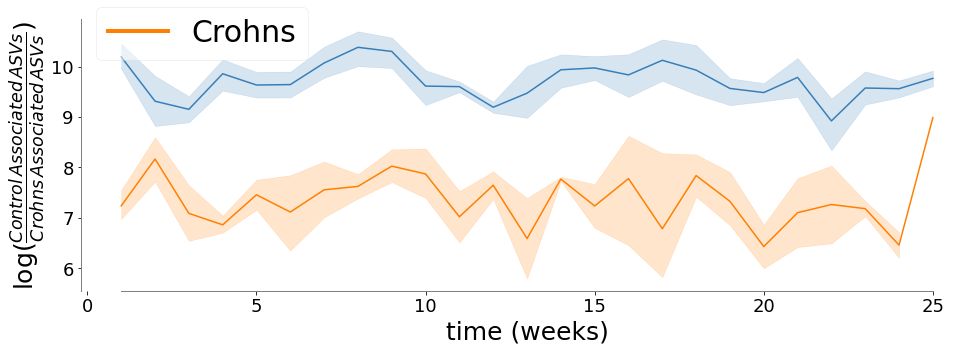

In [10]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

pal = {'Control':'#377eb8','Crohns':'#ff7f00'}

sns.lineplot(y='Current_Natural_Log_Ratio',x='timepoint', hue='ibd', ci=68,
             data=log_ratio_metdata,
             ax=ax, palette=pal)

ax.set_ylabel('$\\log(\\frac{Control\,Associated\,ASVs}'
              '{Crohns\,Associated\,ASVs})$',
              fontsize=25,
              color='black')
ax.set_xlabel('time (weeks)',
              fontsize=25,
              color='black')

# fix spine colors
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(1, 25)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
ax.tick_params(axis='y', colors='black')
ax.tick_params(axis='x', colors='black')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:], loc=2, 
                         bbox_to_anchor=(0.0, 1.1),
                         prop={'size':30},
                         fancybox=True, framealpha=0.5, 
                         ncol=2, markerscale=3,
                         facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

plt.show()


This demonstrates that we can recreate the separation by IBD that we saw in both the `subject_biplot` & `state_subject_ordination`, allowing us to associate specific taxa (in the numerator or denominator) with a particular phenotype.

We can test the statistical power of this log-ratio to differentiate samples by IBD status using a linear mixed effects (LME). 

In [11]:

import statsmodels.formula.api as smf


md = smf.mixedlm("Current_Natural_Log_Ratio ~ timepoint * ibd",
                 log_ratio_metdata,
                 groups=log_ratio_metdata["host_subject_id"])
mdf = md.fit()
print(mdf.summary())


                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Current_Natural_Log_Ratio
No. Observations: 279     Method:             REML                     
No. Groups:       24      Scale:              0.9849                   
Min. group size:  3       Log-Likelihood:     -409.1360                
Max. group size:  16      Converged:          Yes                      
Mean group size:  11.6                                                 
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 9.798     0.175  55.844  0.000   9.454  10.142
ibd[T.Crohns]            -2.271     0.269  -8.437  0.000  -2.798  -1.743
timepoint                -0.006     0.011  -0.539  0.590  -0.027   0.015
timepoint:ibd[T.Crohns]  -0.007     0.018  -0.404  0.686  -0.043   0.028
Gr


From this LME model we can see that indeed the IBD grouping is significant across time. 